# Customer Churn Prediction for SaaS digital platform

**Author:** Yacoub Kanita  
**Role:** Thmanyah - Senior ML Engineer  

This notebook develops a **customer churn prediction pipeline** for a digital subscription platform.  
It covers:  
1. Data understanding & preprocessing
2. Churn label definition (explicit cancellations & inactivity)
3. Feature engineering (engagement, friction, subscription, device, etc.)  
4. Exploratory Data Analysis (EDA)  

The ultimate goal: **predict which users are at risk of churn** and generate insights for retention strategies.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
from dataclasses import dataclass
import re

# Plotting functions for autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# General-purpose scientific and data libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
from sklearn import metrics  # For model evaluation metrics

# Plotting and visualization
import matplotlib.pyplot as plt  # For plotting graphs
# import plotly.offline as py  # Optional: for interactive plots (commented out)

# Configure plots to display inline within Jupyter
%matplotlib inline

# Statistical visualizations
import seaborn as sns

## Data Overview

In [2]:
# Load the JSON file (one JSON per line)
json_file = "/Users/yacoubkanita/Library/CloudStorage/Dropbox/Yaklak/Private/CURRICULUM VITAE/Thamanya task/Sr_ML Engineer/Sr_ML_Engineer_Task/churn-prediction/data/raw/customer_churn_mini.json"
data = pd.read_json(json_file, lines=True)

# Inspect the first rows
data.head(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [3]:
# Dataset shape and info
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
data.info()

# Check missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Rows: 286500, Columns: 18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             286500 non-null  int64  
 1   userId         286500 non-null  object 
 2   sessionId      286500 non-null  int64  
 3   page           286500 non-null  object 
 4   auth           286500 non-null  object 
 5   method         286500 non-null  object 
 6   status         286500 non-null  int64  
 7   level          286500 non-null  object 
 8   itemInSession  286500 non-null  int64  
 9   location       278154 non-null  object 
 10  userAgent      278154 non-null  object 
 11  lastName       278154 non-null  object 
 12  firstName      278154 non-null  object 
 13  registration   278154 non-null  float64
 14  gender         278154 non-null  object 
 15  artist         228108 non-null  object 
 16  song           228108 non-null  object 
 17  len

## 1. Data Cleaning & Preparation
We start by:
- Converting IDs to strings (avoid treating them as numeric features).
- Converting timestamps (`ts`, `registration`) into datetime objects.
- Normalizing categorical columns (`level`, `gender`).
- Dropping irrelevant identifiers (`firstName`, `lastName`).
- Casting low-cardinality text fields into categorical dtype.

#### 1) Basic cleaning

In [4]:
# IDs as strings (never numeric)
id_cols = [c for c in ['userId','sessionId'] if c in data.columns]
for col in id_cols:
    data[col] = data[col].astype(str).str.strip()

# Drop empty userId rows
if 'userId' in data.columns:
    data = data[data['userId'] != '']
    
# Convert epoch-ms columns to datetime
time_cols = [c for c in ['ts','registration'] if c in data.columns]
for col in time_cols:
#    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = pd.to_datetime(data[col], unit='ms', errors='coerce')

data['event_date'] = pd.to_datetime(data['ts'].dt.date)

# Normalize text columns
if 'level' in data.columns:
    data['level'] = data['level'].astype(str).str.lower().replace({'nan':'unknown'})
if 'gender' in data.columns:
    data['gender'] = data['gender'].astype(str).str.upper().replace({'NAN':'U','': 'U'})

# Drop names (not predictive)
for c in ['firstName','lastName']:
    if c in data.columns:
        data = data.drop(columns=c)

# Treat status as categorical (success vs failure)
if 'status' in data.columns:
    data['status'] = data['status'].astype(str).astype('category')

# Define columns we *expect* to be low-card categorical
obj_cols = data.select_dtypes(include='object').columns

# Set a threshold for "low-cardinality" (tune if needed)
MAX_UNIQUE = 50
auto_low_card = [c for c in obj_cols if data[c].nunique(dropna=True) <= MAX_UNIQUE]

# Convert chosen columns to 'category'
for col in auto_low_card:
    data[col] = data[col].astype('category')

# Keep potentially high-card text as plain strings for later aggregation
for col in sorted(set(obj_cols) - set(auto_low_card)):
    data[col] = data[col].astype(str)

In [5]:
# Dataset shape and info
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
data.info()

# Check missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])

data.head(10)

Rows: 278154, Columns: 17
<class 'pandas.core.frame.DataFrame'>
Index: 278154 entries, 0 to 286499
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ts             278154 non-null  datetime64[ns]
 1   userId         278154 non-null  object        
 2   sessionId      278154 non-null  object        
 3   page           278154 non-null  category      
 4   auth           278154 non-null  category      
 5   method         278154 non-null  category      
 6   status         278154 non-null  category      
 7   level          278154 non-null  category      
 8   itemInSession  278154 non-null  int64         
 9   location       278154 non-null  object        
 10  userAgent      278154 non-null  object        
 11  registration   278154 non-null  datetime64[ns]
 12  gender         278154 non-null  category      
 13  artist         278154 non-null  object        
 14  song           278154 non-null 

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,registration,gender,artist,song,length,event_date
0,2018-10-01 00:01:57,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,2018-09-28 22:22:42,M,Martha Tilston,Rockpools,277.89016,2018-10-01
1,2018-10-01 00:03:00,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-09-30 18:20:30,M,Five Iron Frenzy,Canada,236.09424,2018-10-01
2,2018-10-01 00:06:34,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,2018-09-28 22:22:42,M,Adam Lambert,Time For Miracles,282.82730,2018-10-01
3,2018-10-01 00:06:56,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-09-30 18:20:30,M,Enigma,Knocking On Forbidden Doors,262.71302,2018-10-01
4,2018-10-01 00:11:16,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,2018-09-28 22:22:42,M,Daft Punk,Harder Better Faster Stronger,223.60771,2018-10-01
5,2018-10-01 00:11:18,9,8,NextSong,Logged In,PUT,200,free,81,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-09-30 18:20:30,M,The All-American Rejects,Don't Leave Me,208.29995,2018-10-01
6,2018-10-01 00:14:46,9,8,NextSong,Logged In,PUT,200,free,82,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2018-09-30 18:20:30,M,The Velvet Underground / Nico,Run Run Run,260.46649,2018-10-01
7,2018-10-01 00:14:59,30,29,NextSong,Logged In,PUT,200,paid,53,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,2018-09-28 22:22:42,M,Starflyer 59,Passengers (Old Album Version),185.44281,2018-10-01
8,2018-10-01 00:15:05,30,29,Add to Playlist,Logged In,PUT,200,paid,54,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,2018-09-28 22:22:42,M,nan,nan,NaN,2018-10-01
9,2018-10-01 00:18:04,30,29,NextSong,Logged In,PUT,200,paid,55,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,2018-09-28 22:22:42,M,Frumpies,Fuck Kitty,134.47791,2018-10-01


* From your output:
    * The dataset now has 278,154 rows × 17 columns.
    * userId and sessionId are properly strings.
    * ts, registration, and event_date are in datetime64.
    * Low-cardinality text fields (page, auth, method, level, gender) have become categorical.
    * High-cardinality (artist, song, location, userAgent) stayed as object → good choice for later aggregation.
    * Only length has missing values (50,046) — expected, since not all events are song plays.

In [6]:
# Unique values per categorical column
categorical_cols = data.select_dtypes(include='category').columns
for col in categorical_cols:
    print(f"- {col}: {data[col].unique()}")

- page: ['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up', 'Downgrade', ..., 'Submit Downgrade', 'Error', 'Save Settings', 'Cancel', 'Cancellation Confirmation']
Length: 19
Categories (19, object): ['About', 'Add Friend', 'Add to Playlist', 'Cancel', ..., 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
- auth: ['Logged In', 'Cancelled']
Categories (2, object): ['Cancelled', 'Logged In']
- method: ['PUT', 'GET']
Categories (2, object): ['GET', 'PUT']
- status: ['200', '307', '404']
Categories (3, object): ['200', '307', '404']
- level: ['paid', 'free']
Categories (2, object): ['free', 'paid']
- gender: ['M', 'F']
Categories (2, object): ['F', 'M']


In [7]:
# Numerical summary
data.describe().T

,count,mean,min,25%,50%,75%,max,std
ts,278154,2018-10-31 04:08:35.431858176,2018-10-01 00:01:57,2018-10-16 14:11:20,2018-10-30 21:21:12.500000,2018-11-15 07:48:43.249999872,2018-12-03 01:11:16,NaN
itemInSession,278154.0,114.899182,0.0,27.0,70.0,157.0,1321.0,129.851729
registration,278154,2018-08-27 08:33:54.085556992,2018-03-18 13:44:35,2018-08-06 02:26:59,2018-09-11 11:05:02,2018-09-23 03:10:36,2018-11-26 15:49:14,NaN
length,228108.0,249.117182,0.78322,199.88853,234.50077,277.15873,3024.66567,99.235179
event_date,278154,2018-10-30 15:26:17.247136512,2018-10-01 00:00:00,2018-10-16 00:00:00,2018-10-30 00:00:00,2018-11-15 00:00:00,2018-12-03 00:00:00,NaN


## 2. Churn Label Definition
Churn is defined as:
- **Explicit Churn**: Users who reached `Cancellation Confirmation` page with `status=200`.
- **Inactivity Churn**: Users with no activity in the last `N=30` days.
Users may fall into both groups; we prioritize **explicit churn** as the label.

#### 2.0) Config & helpers

In [8]:
data['page'].value_counts()

page
NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: count, dtype: int64

In [9]:
# Churn config & helpers
@dataclass
class ChurnConfig:
    explicit_cancel_page: str = "Cancellation Confirmation"
    inactivity_days: int = 30          # no events in the last N days -> churn
    min_tenure_days: int = 0           # optionally ignore "very new" users when labeling inactivity
    use_cancel_page_also: list = None  # if we want to treat additional pages as explicit churn
                                       # e.g., ["Cancel"]  (not recommended unless business confirms)

cfg = ChurnConfig(
    explicit_cancel_page="Cancellation Confirmation",
    inactivity_days=30,
    min_tenure_days=0,
    use_cancel_page_also=None,  # or ["Cancel"] if we decide to include it
)

# Dataset boundaries per user
dataset_end = data['ts'].max()
first_event_per_user = data.groupby('userId')['ts'].min().rename('first_ts')
last_event_per_user  = data.groupby('userId')['ts'].max().rename('last_ts')
tenure_days = (last_event_per_user - first_event_per_user).dt.days.rename('tenure_days')


#### 2.1) Compute Explicit Cancels

In [10]:
# Explicit churners (only successful cancels)
cancel_mask = (data['page'].astype(str) == "Cancellation Confirmation") & (data['status'].astype(str) == '200')
explicit_cancel_users = set(data.loc[cancel_mask, 'userId'].unique())

# include other cancel-like pages
if cfg.use_cancel_page_also:
    for p in cfg.use_cancel_page_also:
        explicit_cancel_users |= set(data.loc[data['page'].astype(str).eq(p), 'userId'].unique())

#### 2.2) Compute Inactivity Churn

In [11]:
# Inactivity churn
inactive_series = last_event_per_user[
    (dataset_end - last_event_per_user) >= pd.Timedelta(days=cfg.inactivity_days)
]

# Optionally exclude very-new users (cold start) from being labeled inactive
if cfg.min_tenure_days > 0:
    long_enough = tenure_days[tenure_days >= cfg.min_tenure_days].index
    inactive_users = set(inactive_series.index.intersection(long_enough))
else:
    inactive_users = set(inactive_series.index)

#### 2.3) Churned Users

In [12]:
# Label assignment
churn_users = explicit_cancel_users.union(inactive_users)

labels = (
    pd.concat([first_event_per_user, last_event_per_user, tenure_days], axis=1)
      .reset_index()
      .rename(columns={'index':'userId'})
)

labels['label_reason'] = np.where(
    labels['userId'].isin(explicit_cancel_users), 'cancel',
    np.where(labels['userId'].isin(inactive_users), 'inactive', 'active')
)
labels['label_churn'] = (labels['label_reason'] != 'active').astype(int)

#### 2.3) Labeled Data Summary

In [13]:
# Quick diagnostics
print("=== Label summary ===")
print(labels['label_reason'].value_counts(dropna=False))
print("\nChurn rate:", labels['label_churn'].mean().round(4))
print("\nDate range:",
      f"first={data['ts'].min().date()}  last={data['ts'].max().date()}",
      f"(inactivity_days={cfg.inactivity_days}, min_tenure_days={cfg.min_tenure_days})")

=== Label summary ===
label_reason
active      164
cancel       52
inactive      9
Name: count, dtype: int64

Churn rate: 0.2711

Date range: first=2018-10-01  last=2018-12-03 (inactivity_days=30, min_tenure_days=0)


In [14]:
# sanity checks
# How many users have both explicit cancel and inactivity? (should be possible but small)
both = set(explicit_cancel_users).intersection(inactive_users)
print(f"\nUsers with BOTH explicit cancel and inactivity: {len(both)}")


Users with BOTH explicit cancel and inactivity: 36


In [15]:
labels['label_reason'] = np.where(
    labels['userId'].isin(explicit_cancel_users), 'cancel',
    np.where(labels['userId'].isin(inactive_users), 'inactive', 'active')
)

labels.loc[labels['userId'].isin(both), 'label_reason'] = 'cancel+inactive'

In [16]:
# Keep handy sets for later use if needed
label_sets = {
    'explicit_cancel_users': explicit_cancel_users,
    'inactive_users': inactive_users,
    'churn_users': churn_users
}

labels.head()

,userId,first_ts,last_ts,tenure_days,label_reason,label_churn
0,10,2018-10-08 02:20:20,2018-11-19 12:49:48,42,active,0
1,100,2018-10-02 15:04:22,2018-11-30 14:15:49,58,active,0
2,100001,2018-10-01 06:48:24,2018-10-02 16:36:45,1,cancel+inactive,1
3,100002,2018-10-08 22:57:25,2018-12-03 01:11:16,55,active,0
4,100003,2018-10-09 15:53:40,2018-10-11 16:19:41,2,cancel+inactive,1


## 3. Feature Engineering
We aggregate event-level logs into user-level features:

- **Engagement**: Songs played, unique artists, session counts  
- **Interactions**: Thumbs Up/Down, Playlists, Friends  
- **Subscription**: Paid/free ratios, Upgrades/Downgrades  
- **Friction**: Failed attempts, error status codes  
- **Device & Location**: OS, last known state  
- **Recency & Tenure**: Active days, inactivity gaps  

#### User level

In [17]:
# ==== Step 3: Feature Engineering (user-level) ====

# 3.1 Basic aggregates
g_user = data.groupby('userId')

features = pd.DataFrame(index=g_user.size().index)

# Total events
features['total_events'] = g_user.size()

# Sessions
features['sessions'] = g_user['sessionId'].nunique()

# Active days
features['days_active'] = g_user['event_date'].nunique()

# First & last activity
features['first_ts'] = g_user['ts'].min()
features['last_ts']  = g_user['ts'].max()
features['tenure_days'] = (features['last_ts'] - features['first_ts']).dt.days
features['recency_days'] = (dataset_end - features['last_ts']).dt.days

#### Engagement features

In [18]:
# Song plays (NextSong events)
nextsong = data[data['page'] == 'NextSong']
song_g = nextsong.groupby('userId')

features['songs_played'] = song_g.size()
features['unique_artists'] = song_g['artist'].nunique()
features['total_song_length'] = song_g['length'].sum()
features['avg_song_length']   = song_g['length'].mean()

#### Social/interaction features

In [20]:
# Utility: count user events by page + status
def count_page_events(page_name, status_code=None):
    df = data[data['page'] == page_name]
    if status_code is not None:  # filter by specific status
        df = df[df['status'] == status_code]
    return df.groupby('userId').size()

In [21]:
# List of important page events to track
page_events = [
    ('Home', 'home_page_landing'),
    ('Thumbs Up', 'thumbs_up'),
    ('Thumbs Down', 'thumbs_down'),
    ('Add to Playlist', 'add_playlist'),
    ('Add Friend', 'add_friend'),
    ('Roll Advert', 'ads_watched'),
    ('Help', 'help_clicks'),
    ('NextSong', 'nextsong_clicks'),
    ('Settings', 'settings_clicks'),
    ('Save Settings', 'settings_save'),
    ('Upgrade', 'upgrade_clicks'),
    ('Submit Upgrade', 'upgrade_submit'),
    ('Downgrade', 'downgrade_clicks'),
    ('Submit Downgrade', 'downgrade_submit'),
    ('Logout', 'logout_clicks'),
    ('Cancel', 'cancel_clicks'),
    ('Cancellation Confirmation', 'cancellation_confirmation')
]

# Loop through and add both successful + failed features
for page, col in page_events:
    # Successful events (status == 200)
    success_counts = count_page_events(page, status_code='200')
    features[f"{col}_success"] = success_counts

    # Failed events = total - successful
    total_counts = count_page_events(page)
    failed_counts = total_counts.sub(features[f"{col}_success"], fill_value=0)
    features[f"{col}_failed"] = failed_counts
    print(f"page: {page}: {total_counts.sum()} events, _success={success_counts.sum()}, _failed={failed_counts.sum()}")

# Fill missing with 0 (users who never had that event)
features = features.fillna(0)

page: Home: 10082 events, _success=10082, _failed=0.0
page: Thumbs Up: 12551 events, _success=0, _failed=12551.0
page: Thumbs Down: 2546 events, _success=0, _failed=2546.0
page: Add to Playlist: 6526 events, _success=6526, _failed=0.0
page: Add Friend: 4277 events, _success=0, _failed=4277.0
page: Roll Advert: 3933 events, _success=3933, _failed=0.0
page: Help: 1454 events, _success=1454, _failed=0.0
page: NextSong: 228108 events, _success=228108, _failed=0
page: Settings: 1514 events, _success=1514, _failed=0.0
page: Save Settings: 310 events, _success=0, _failed=310.0
page: Upgrade: 499 events, _success=499, _failed=0.0
page: Submit Upgrade: 159 events, _success=0, _failed=159.0
page: Downgrade: 2055 events, _success=2055, _failed=0.0
page: Submit Downgrade: 63 events, _success=0, _failed=63.0
page: Logout: 3226 events, _success=0, _failed=3226.0
page: Cancel: 52 events, _success=0, _failed=52.0
page: Cancellation Confirmation: 52 events, _success=52, _failed=0.0


#### Subscription level usage

In [22]:
level_counts = (
    data.pivot_table(index='userId', columns='level', values='ts', aggfunc='count', fill_value=0)
    .add_prefix('level_')
)
features = features.join(level_counts)

if 'level_paid' in features.columns:
    total_level = features.filter(like='level_').sum(axis=1)
    features['paid_ratio'] = features['level_paid'] / (total_level + 1e-6) # calc % of paid event

#### Device & location

In [23]:
# Extract OS from userAgent
def parse_os(ua):
    ua = str(ua)
    if 'iPhone' in ua or 'iPad' in ua: return 'iOS'
    if 'Android' in ua: return 'Android'
    if 'Mac' in ua: return 'Mac'
    if 'Windows' in ua: return 'Windows'
    return 'Other'

features['device_os'] = data.groupby('userId')['userAgent'].last().apply(parse_os)

In [24]:
# Extract state from location ("City, ST")
def extract_state(loc):
    if not isinstance(loc, str) or ',' not in loc:
        return 'NA'
    return loc.split(',')[-1].strip()

features['state'] = data.groupby('userId')['location'].last().apply(extract_state)

#### Error status features

In [25]:
# Status error counts
status_g = data.groupby(['userId','status']).size().unstack(fill_value=0)
status_g = status_g.add_prefix('status_')

# Error rate = all non-200 statuses / total
status_cols = [c for c in status_g.columns if c != 'status_200']
status_g['error_events'] = status_g[status_cols].sum(axis=1)
status_g['error_rate'] = status_g['error_events'] / (status_g.sum(axis=1) + 1e-6)

features = features.join(status_g)

#### Merge with labels

In [26]:
# Merge with churn labels
features = features.merge(labels[['userId','label_churn','label_reason']], 
                          left_index=True, right_on='userId', how='left')

In [27]:
# Dataset shape and info
print(f"Final features shape, Rows: {features.shape[0]}, Columns: {features.shape[1]}")
features.info()

# Check missing values
missing = features.isnull().sum()
print("Missing values:\n", missing[missing > 0])

features.describe().T

Final features shape, Rows: 225, Columns: 58
<class 'pandas.core.frame.DataFrame'>
Index: 225 entries, 0 to 224
Data columns (total 58 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   total_events                       225 non-null    int64         
 1   sessions                           225 non-null    int64         
 2   days_active                        225 non-null    int64         
 3   first_ts                           225 non-null    datetime64[ns]
 4   last_ts                            225 non-null    datetime64[ns]
 5   tenure_days                        225 non-null    int64         
 6   recency_days                       225 non-null    int64         
 7   songs_played                       225 non-null    int64         
 8   unique_artists                     225 non-null    int64         
 9   total_song_length                  225 non-null    float64       
 10

,count,mean,min,25%,50%,75%,max,std
total_events,225.0,1236.24,6.0,296.0,848.0,1863.0,9632.0,1329.531716
sessions,225.0,14.115556,1.0,6.0,10.0,18.0,107.0,14.646885
days_active,225.0,13.884444,1.0,6.0,11.0,19.0,59.0,11.073818
first_ts,225,2018-10-07 10:42:29,2018-10-01 00:01:57,2018-10-01 18:32:53,2018-10-03 17:01:20,2018-10-08 11:51:41,2018-11-28 04:01:37,NaN
last_ts,225,2018-11-18 00:16:27.186666496,2018-10-01 18:04:45,2018-11-13 14:15:34,2018-11-26 12:13:37,2018-11-29 17:49:21,2018-12-03 01:11:16,NaN
tenure_days,225.0,41.115556,0.0,29.0,49.0,57.0,60.0,18.9679
recency_days,225.0,14.617778,0.0,3.0,6.0,19.0,62.0,16.647223
songs_played,225.0,1013.813333,3.0,230.0,675.0,1571.0,8002.0,1104.960779
unique_artists,225.0,696.377778,3.0,207.0,555.0,1098.0,3544.0,603.95187
total_song_length,225.0,252558.320652,691.66884,57633.17564,168093.78703,392401.495,1991154.91558,275396.403885


##### Feature Engineering – Observations

After completing the feature engineering step and inspecting the dataset:

- The **final feature matrix** contains 225 rows (users) and 58 columns (features).  
- Upon checking the summary statistics and missing values:
  - Many newly engineered columns (e.g., `home_page_landing_failed`, `thumbs_up_success`, `thumbs_down_success`, `add_playlist_failed`, `add_friend_success`, `ads_watched_failed`) contain **only zero values** across all users.  
  - This indicates that **some events never occurred** in the dataset with the corresponding status code. For example:
    - Pages like `"Home"` almost always succeed (status = 200), so `"home_page_landing_failed"` is always zero.  
    - Rare actions like `"Add Friend"` or `"Roll Advert"` may not exist in the data, producing all-zero success/failed columns.  

✅ **Conclusion**:  
- The zero-only columns are **not mistakes in the feature engineering code** — they simply reflect the nature of the dataset.  
- These columns carry **no predictive power** and can be safely dropped.  
- Next step will be to **remove all-constant** to keep the feature matrix clean and reduce noise before model training.

In [28]:
# Drop columns with only 1 unique value (constant)
constant_cols = [c for c in features.columns if features[c].nunique(dropna=False) == 1]

print("Dropping constant columns:", constant_cols)
features = features.drop(columns=constant_cols)

Dropping constant columns: ['home_page_landing_failed', 'thumbs_up_success', 'thumbs_down_success', 'add_playlist_failed', 'add_friend_success', 'ads_watched_failed', 'help_clicks_failed', 'nextsong_clicks_failed', 'settings_clicks_failed', 'settings_save_success', 'upgrade_clicks_failed', 'upgrade_submit_success', 'downgrade_clicks_failed', 'downgrade_submit_success', 'logout_clicks_success', 'cancel_clicks_success', 'cancellation_confirmation_failed']


## EDA## 4. Exploratory Data Analysis (EDA)
We explore target distribution, feature distributions, and bivariate relationships with churn.

In [29]:
# Separate churned vs active
churned = features[features['label_churn'] == 1]
active  = features[features['label_churn'] == 0]

#### Target distribution

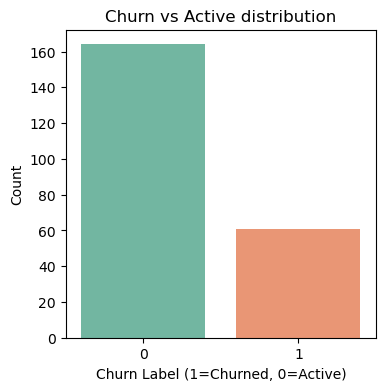

Churn Rate: 0.271


In [30]:
# --- 4.1 Target distribution ---
plt.figure(figsize=(4,4))
sns.countplot(x='label_churn', data=features, palette='Set2')
plt.title("Churn vs Active distribution")
plt.xlabel("Churn Label (1=Churned, 0=Active)")
plt.ylabel("Count")
plt.show()

print("Churn Rate:", features['label_churn'].mean().round(3))

#### Numeric Features Distributions

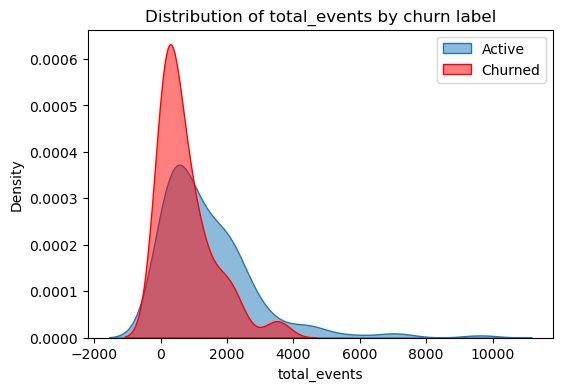

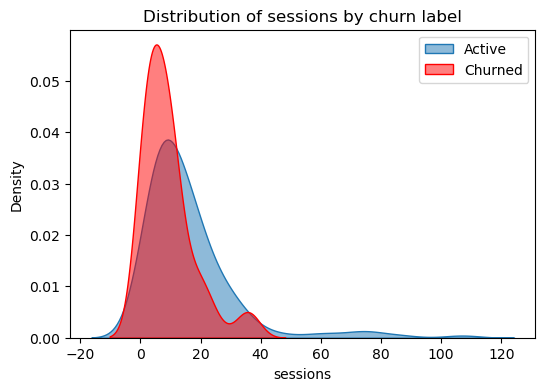

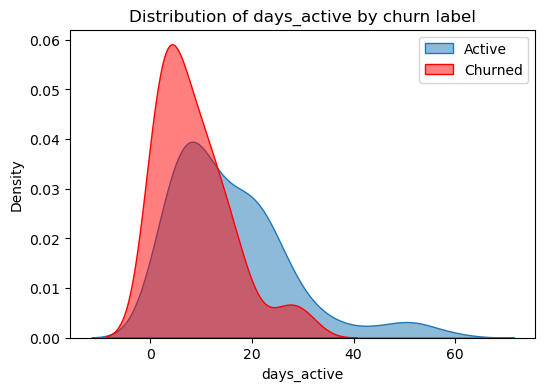

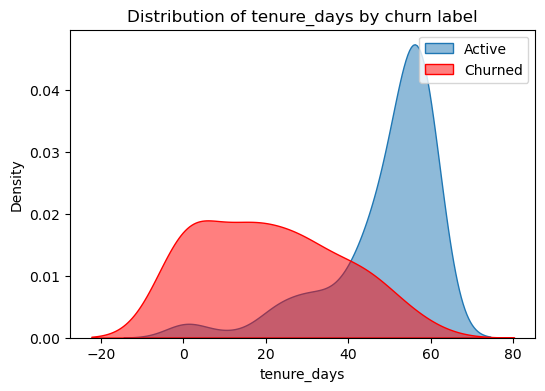

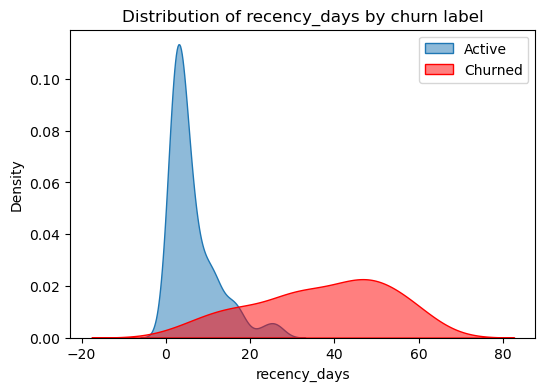

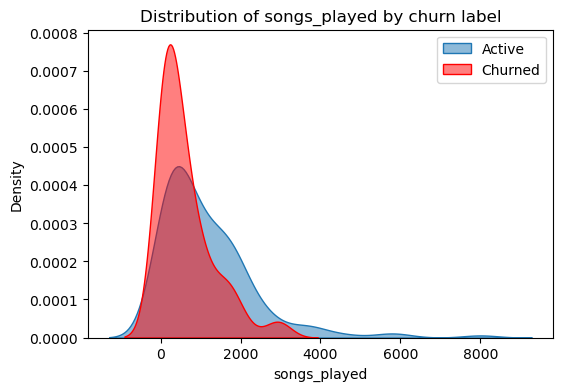

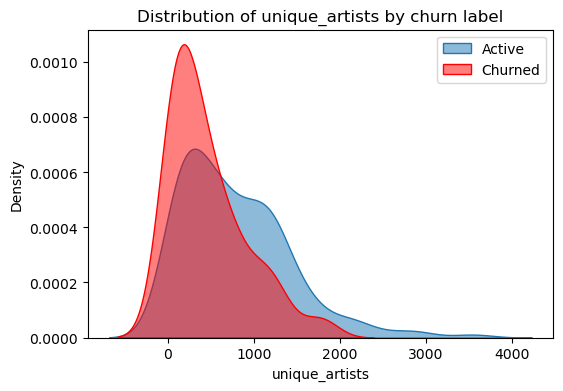

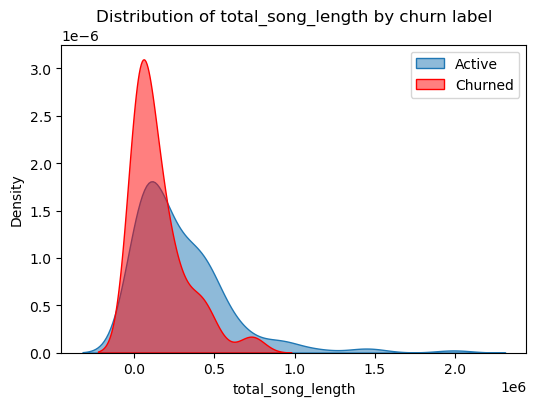

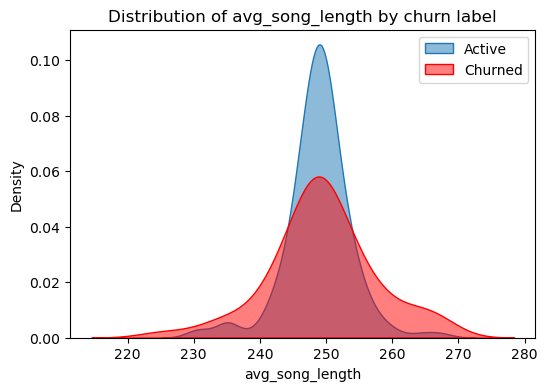

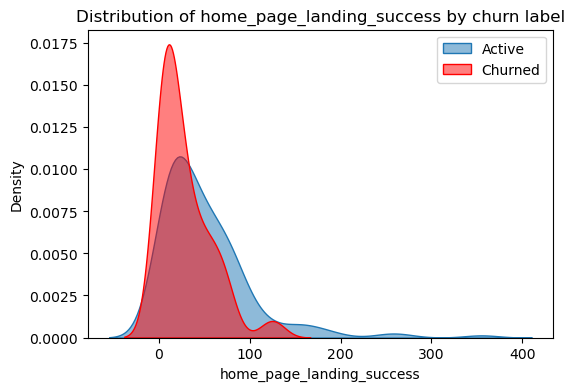

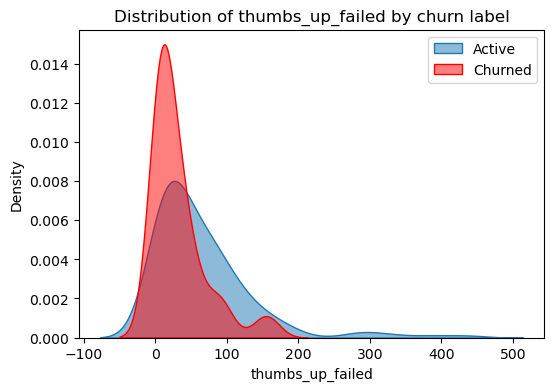

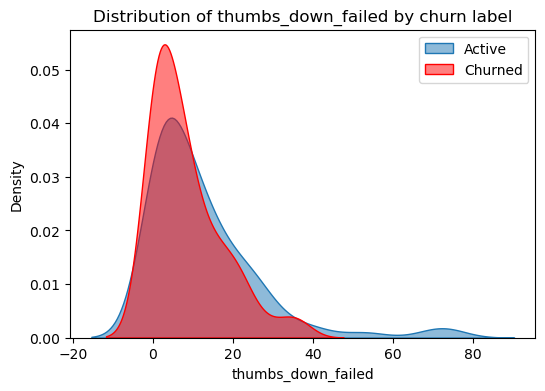

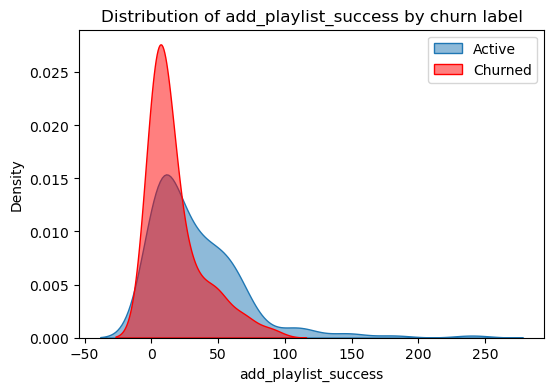

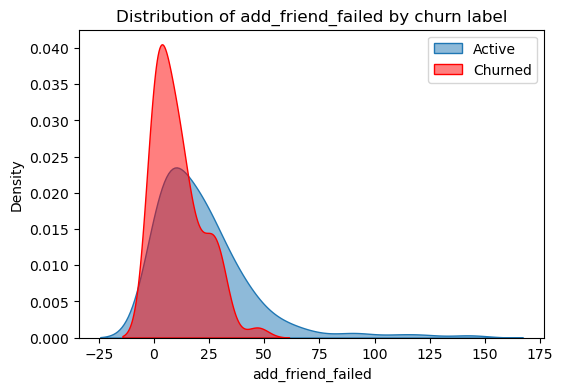

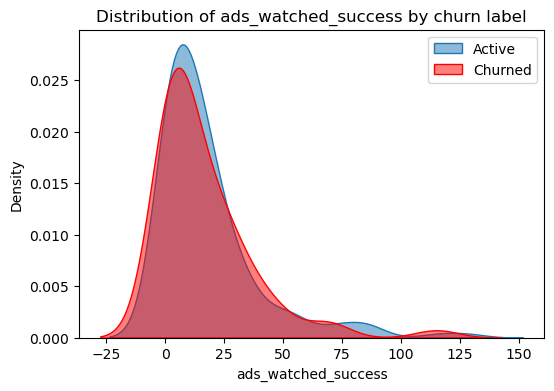

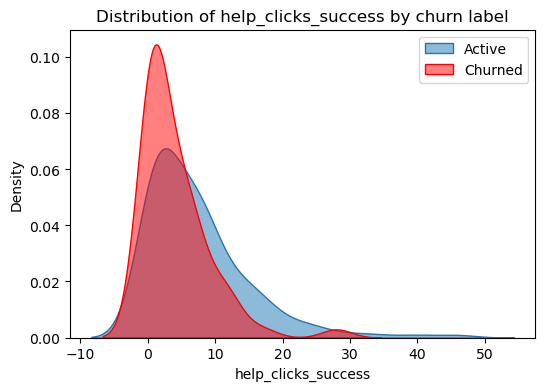

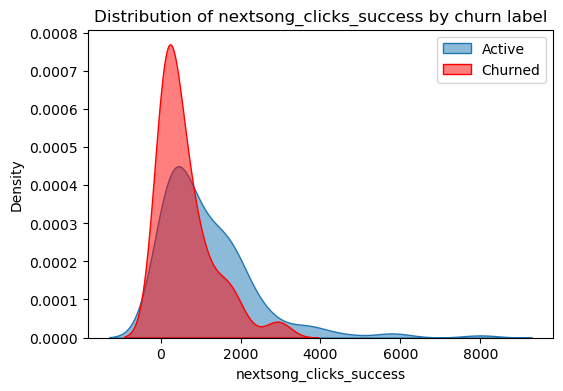

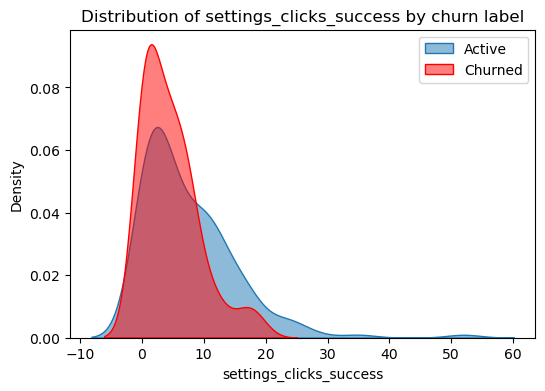

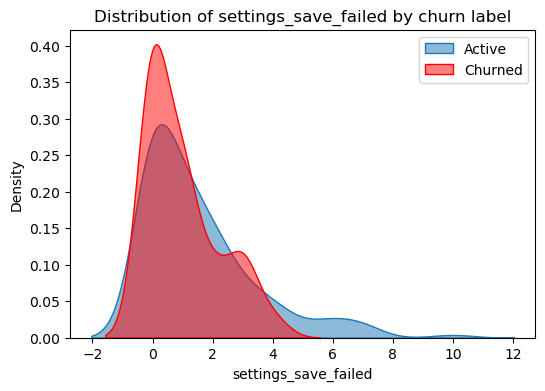

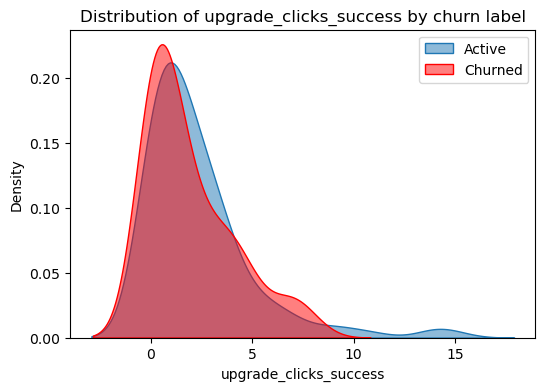

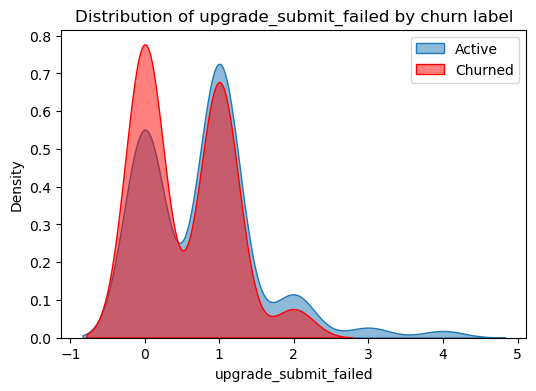

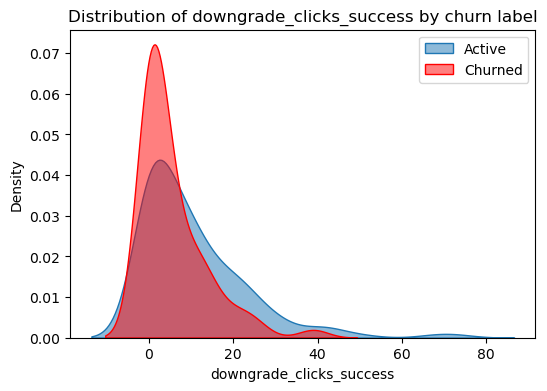

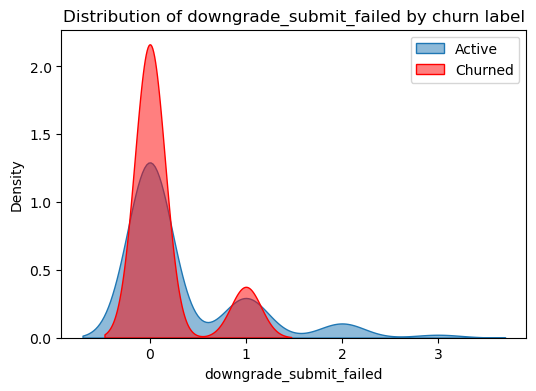

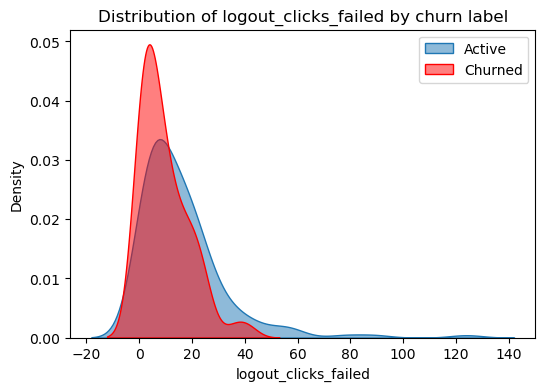

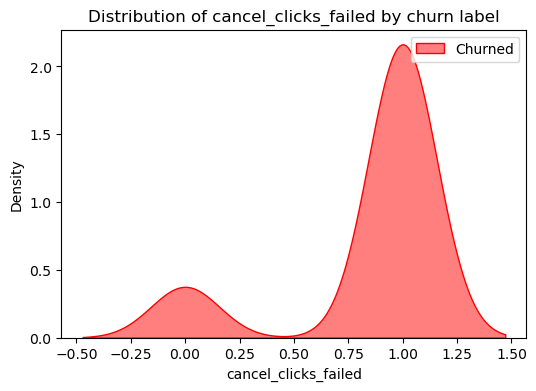

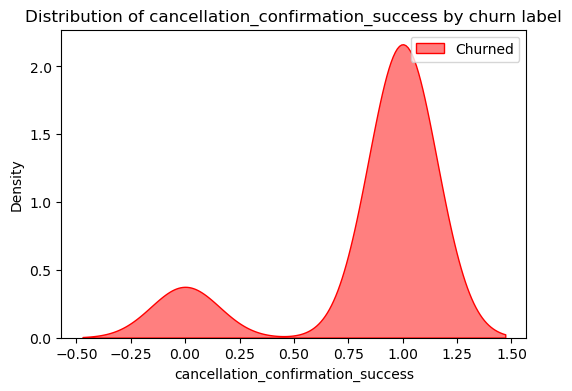

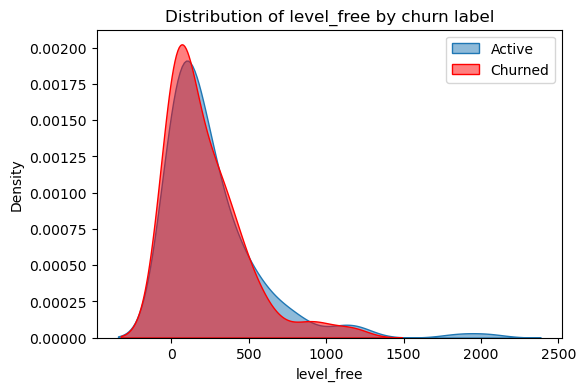

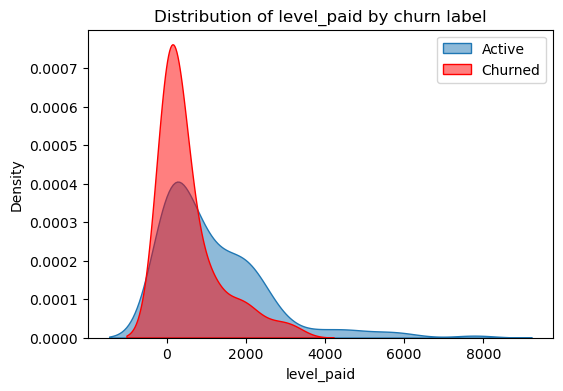

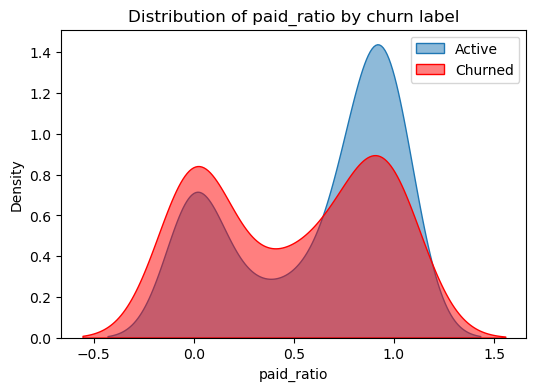

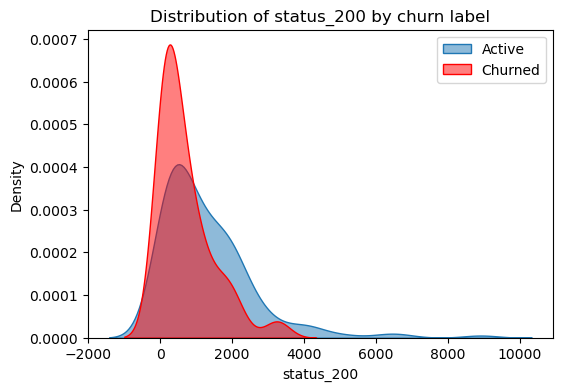

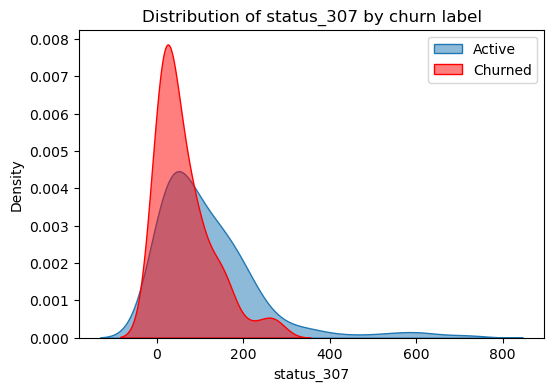

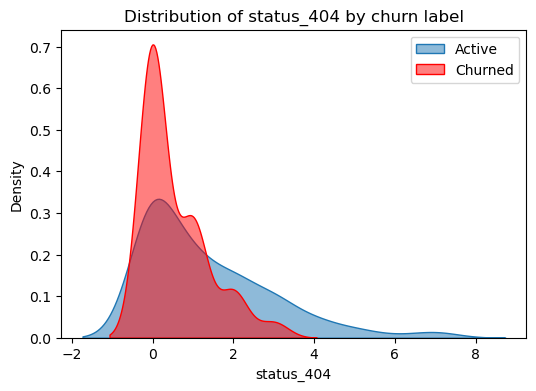

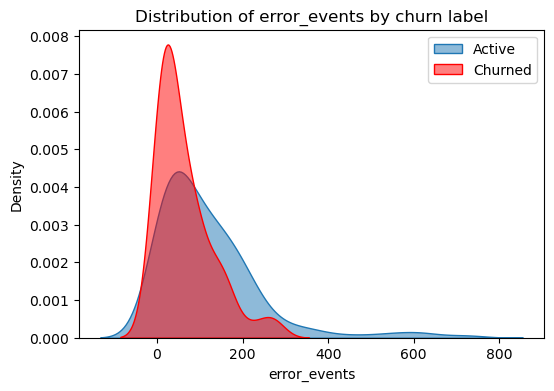

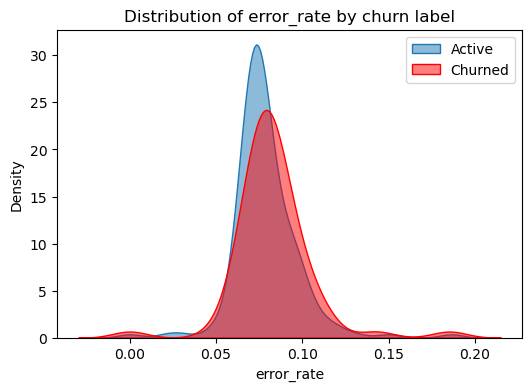

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


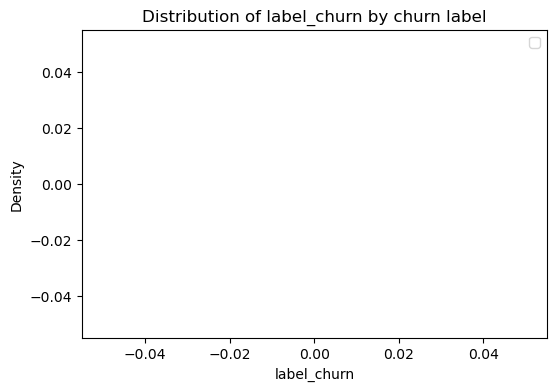

In [31]:
# --- 4.2 Compare churn vs active for key numeric features ---
num_cols = features.select_dtypes(include='number')

# num_cols = [
#     'songs_played','thumbs_up_success','thumbs_down_success',
#     'add_playlist_success','add_friend_success','ads_watched_success',
#     'upgrade_clicks_success','downgrade_clicks_success',
#     'tenure_days','recency_days','error_rate'
# ]
num_cols = [c for c in num_cols if c in features.columns]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=active, x=col, label='Active', fill=True, alpha=0.5)
    sns.kdeplot(data=churned, x=col, label='Churned', fill=True, alpha=0.5, color="red")
    plt.title(f"Distribution of {col} by churn label")
    plt.legend()
    plt.show()

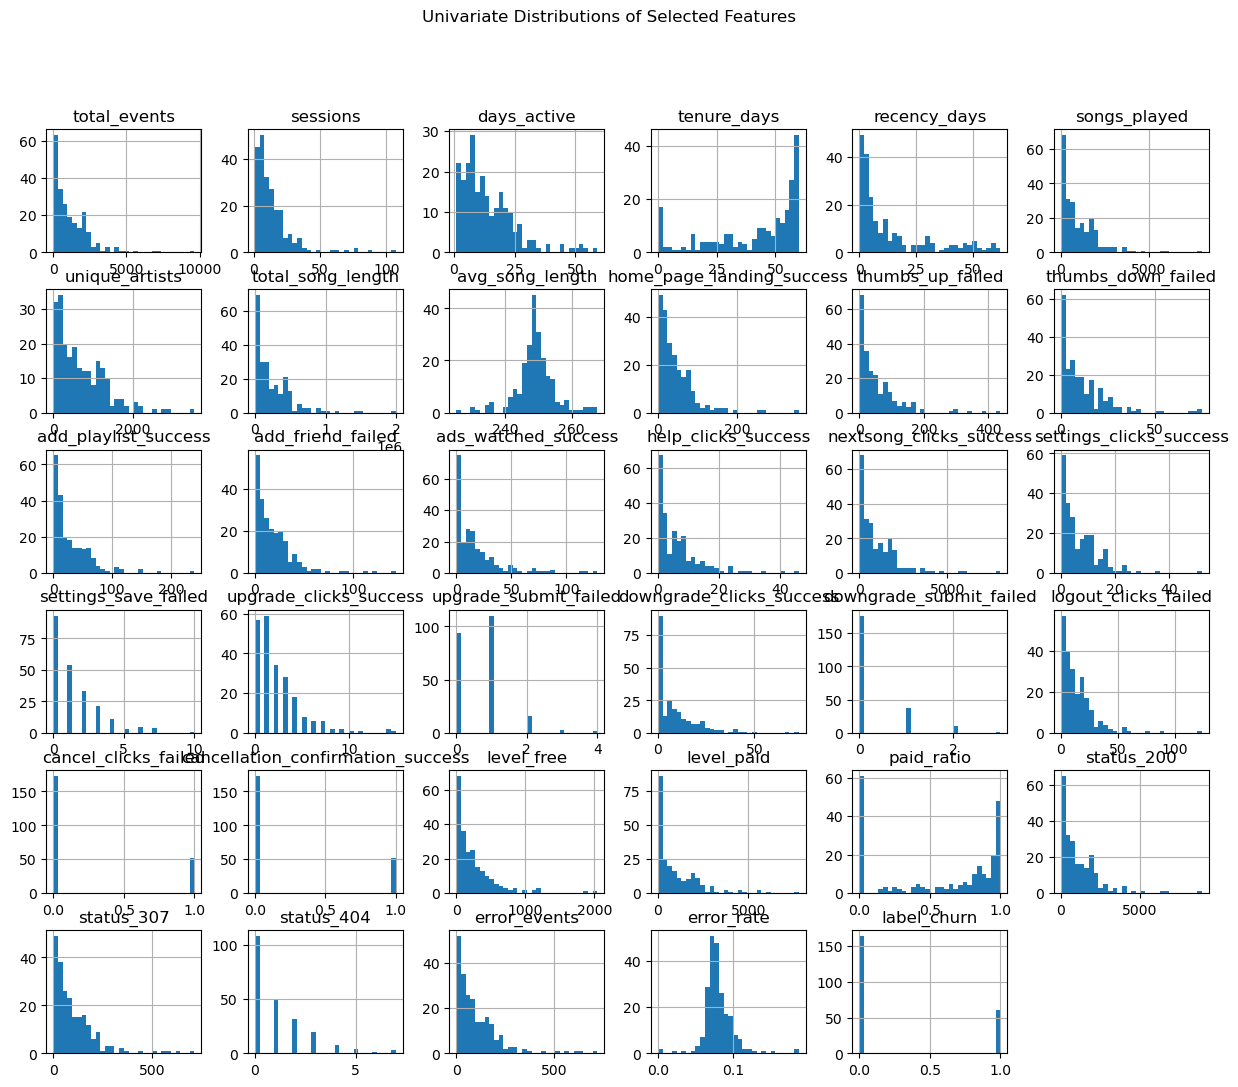

In [32]:
# Histograms
features[num_cols].hist(bins=30, figsize=(15,12))
plt.suptitle("Univariate Distributions of Selected Features")
plt.show()

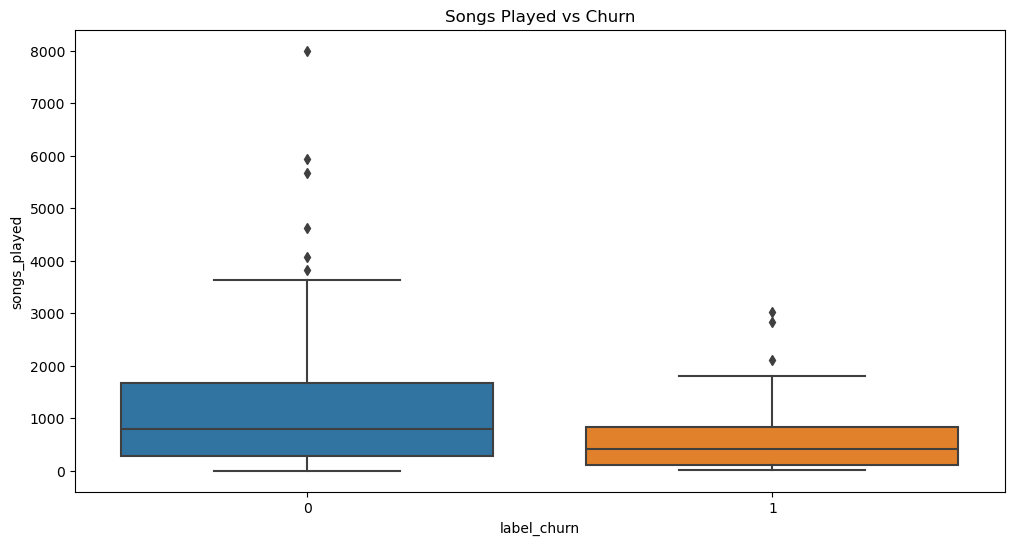

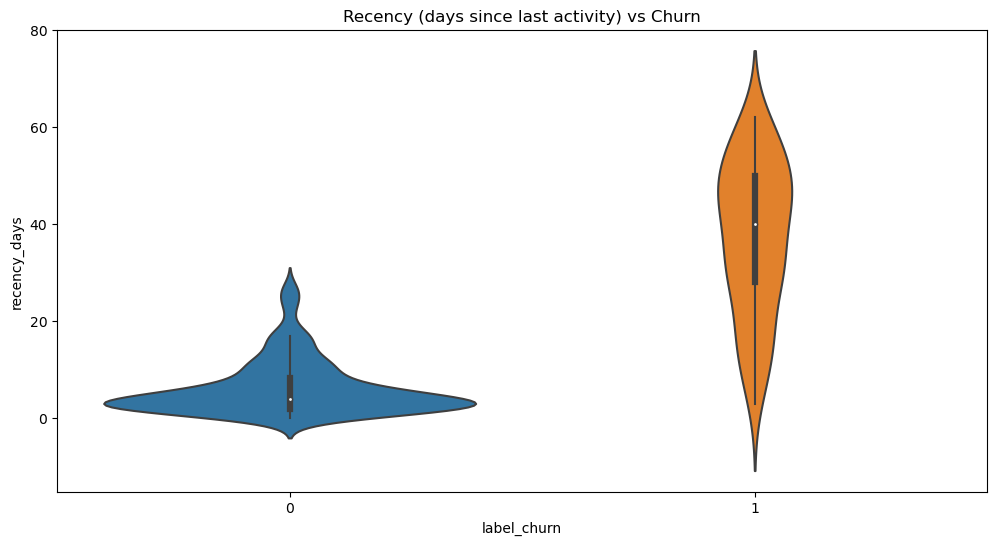

In [33]:
# Boxplots / violin plots for distribution by churn status
plt.figure(figsize=(12,6))
sns.boxplot(x='label_churn', y='songs_played', data=features)
plt.title("Songs Played vs Churn")
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(x='label_churn', y='recency_days', data=features)
plt.title("Recency (days since last activity) vs Churn")
plt.show()

#### Categorical Features

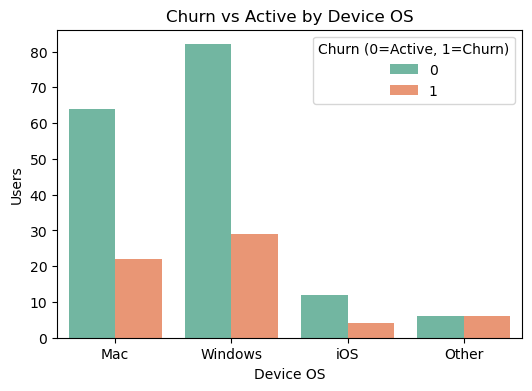

In [34]:
# --- 4.3 Device OS ---
if 'device_os' in features.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(
        x='device_os',
        hue=features['label_churn'].astype(str),  # convert to string
        data=features,
        palette='Set2'
    )
    plt.title("Churn vs Active by Device OS")
    plt.ylabel("Users")
    plt.xlabel("Device OS")
    plt.legend(title="Churn (0=Active, 1=Churn)")
    plt.show()

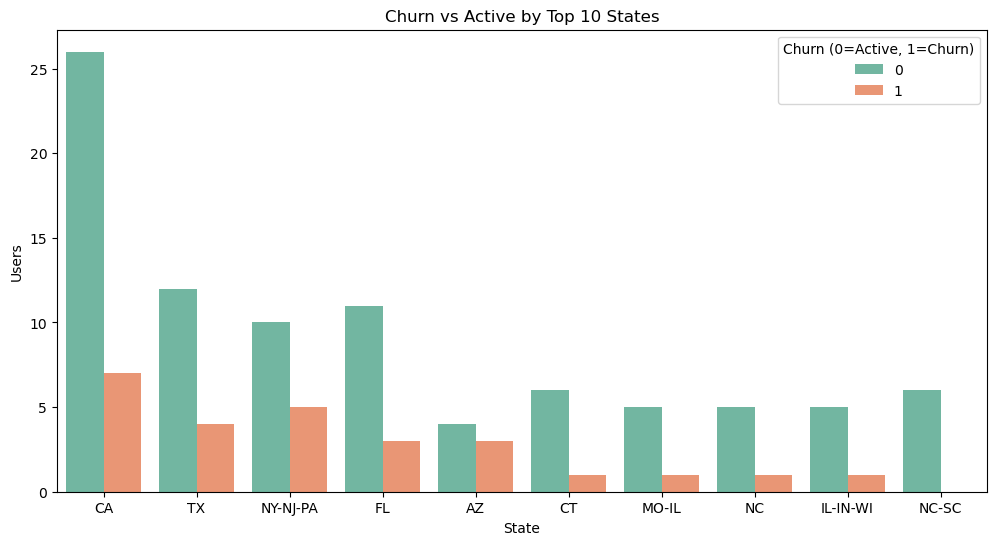

In [35]:
# --- 4.4 State (Top 10 only) ---
if 'state' in features.columns:
    # Find top 10 states by number of users
    top_states = (features['state'].value_counts()
                  .nlargest(10)
                  .index)

    plt.figure(figsize=(12,6))
    sns.countplot(
        x='state',
        hue=features['label_churn'].astype(str),  # convert to string for legend
        data=features[features['state'].isin(top_states)],
        order=top_states,   # ensures sorted by overall counts
        palette='Set2'
    )
    plt.title("Churn vs Active by Top 10 States")
    plt.ylabel("Users")
    plt.xlabel("State")
    plt.legend(title="Churn (0=Active, 1=Churn)")
    plt.show()

In [36]:
# Mean feature values by churn vs active
churn_means = features.groupby('label_churn')[num_cols].mean().T
churn_means.columns = ['Active','Churn']
churn_means['Diff'] = churn_means['Active'] - churn_means['Churn']
churn_means.sort_values('Diff', ascending=False)

,Active,Churn,Diff
total_song_length,289299.249883,153779.428948,135519.820935
total_events,1412.609756,762.065574,650.544182
level_paid,1152.981707,546.622951,606.358756
status_200,1293.359756,698.475410,594.884346
songs_played,1161.012195,618.065574,542.946621
nextsong_clicks_success,1161.012195,618.065574,542.946621
unique_artists,783.695122,461.622951,322.072171
error_events,119.250000,63.590164,55.659836
status_307,117.914634,63.049180,54.865454
level_free,259.628049,215.442623,44.185426


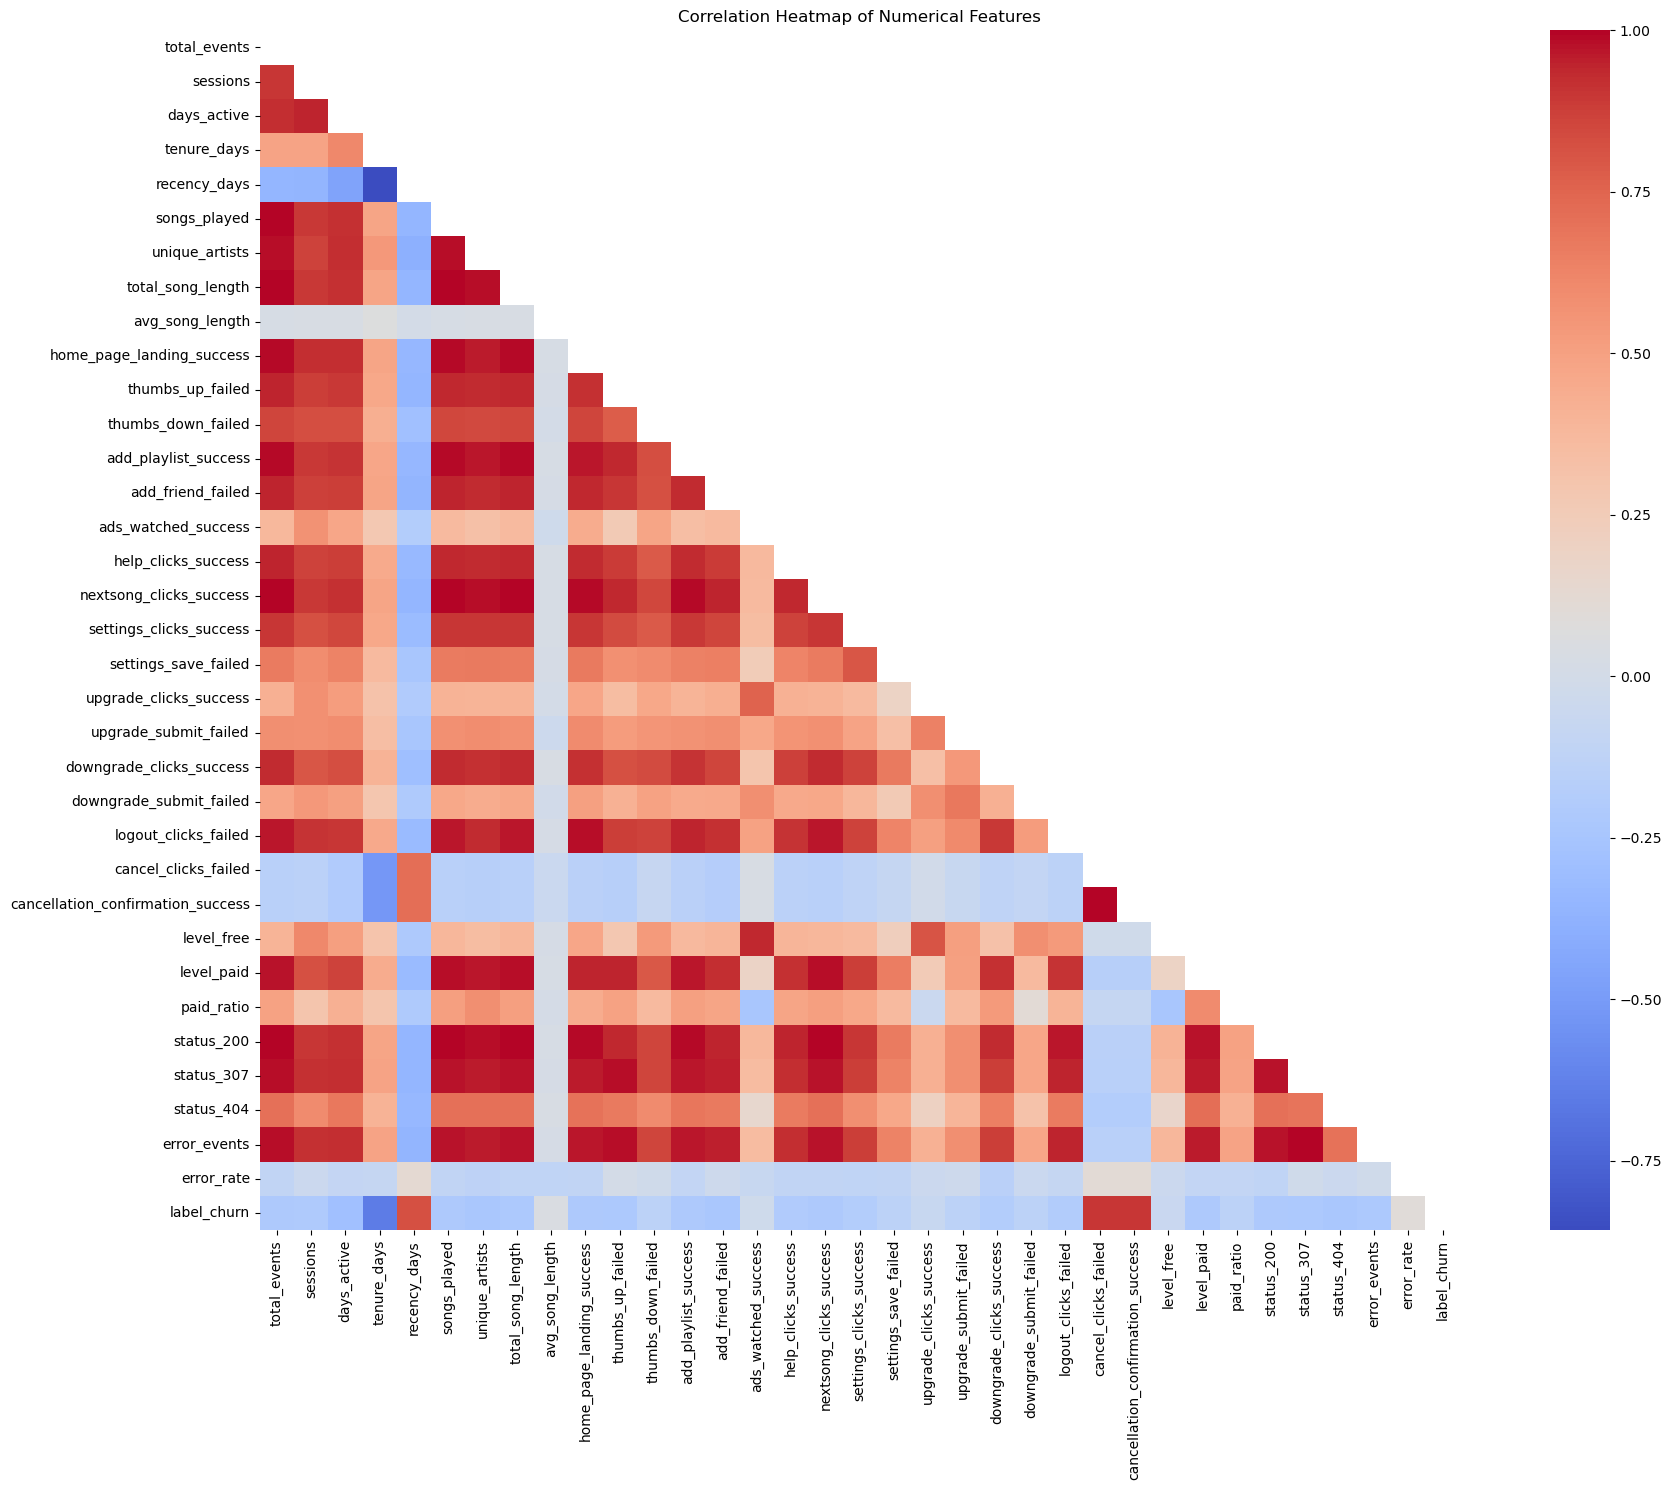

In [37]:
# Select only numeric columns
numeric_data = features.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, mask=np.triu(corr))
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [38]:
# 3. Save to CSV
csv_file = "/Users/yacoubkanita/Library/CloudStorage/Dropbox/Yaklak/Private/CURRICULUM VITAE/Thamanya task/Sr_ML Engineer/Sr_ML_Engineer_Task/churn-prediction/data/processed/customer_churn_features.csv"
features.to_csv(csv_file, index=False)

print(f"✅ JSON converted to CSV and saved at {csv_file}")

✅ JSON converted to CSV and saved at /Users/yacoubkanita/Library/CloudStorage/Dropbox/Yaklak/Private/CURRICULUM VITAE/Thamanya task/Sr_ML Engineer/Sr_ML_Engineer_Task/churn-prediction/data/processed/customer_churn_features.csv


## 5. Conclusions & Next Steps
- Churn rate is ~XX%, indicating [balanced/imbalanced dataset].
- Key churn signals include [songs played, recency, upgrade failures].
- Next steps: train baseline models (Logistic Regression, Random Forest, XGBoost).